In [3]:
import numpy as np
def relu_function(x):
    return np.maximum(0,x)

x = np.array([-1,1,2])
relu_function(x)

array([0, 1, 2])

Populating the interactive namespace from numpy and matplotlib


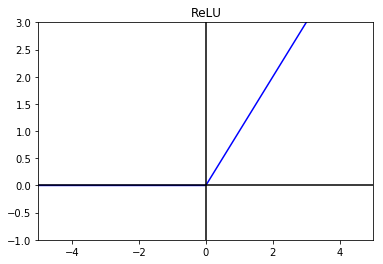

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5,5,200)

plt.plot(z, relu_function(z), "b")
plt.plot([-5, 5], [0, 0], 'k')
plt.plot([0, 0], [-1, 3], 'k')
plt.title("ReLU")
plt.axis([-5, 5, -1, 3])
plt.show()

In [5]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)
x = np.array([-1,1,2])
leaky_relu(x)

array([-0.01,  1.  ,  2.  ])

Populating the interactive namespace from numpy and matplotlib


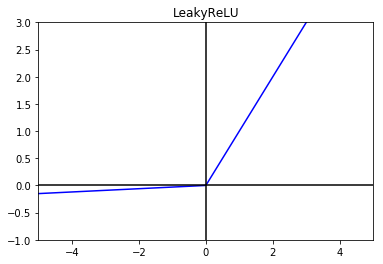

In [6]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np

z = np.linspace(-5,5,200)

plt.plot(z, leaky_relu(z, 0.03), "b")
plt.plot([-5, 5], [0, 0], 'k')
plt.plot([0, 0], [-1, 3], 'k')
plt.title("LeakyReLU")
plt.axis([-5, 5, -1, 3])
plt.show()

## 使用GAN 產生手寫辨識數據

In [7]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np

C:\ProgramData\Anaconda3_2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
def build_discriminator():

    model = Sequential()

    img_shape = (28, 28, 1)
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [10]:
?Adam

In [11]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [12]:
latent_dim = 100
def build_generator():

    model = Sequential()

    img_shape = (28, 28, 1)
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    
    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [13]:
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              525312    
__________

In [14]:
z = Input(shape=(latent_dim,))
img = generator(z)

In [15]:
discriminator.trainable = False

In [16]:
validity = discriminator(img)

In [17]:
validity 

<tf.Tensor 'model_2/sequential_2/dense_6/Sigmoid:0' shape=(?, 1) dtype=float32>

In [19]:
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [20]:
import os 
os.mkdir('images')

In [21]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # 正规化图片尺度至0  -  1的范围
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

In [ ]:
batch_size=32
sample_interval=200
epochs = 5000

(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):


    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, valid)


    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    if epoch % sample_interval == 0:
        sample_images(epoch)